In [1]:
cd "C:\Users\Alexandr\Documents\GitHub\smartphone-price-analysis\Data\"

C:\Users\Alexandr\Documents\GitHub\smartphone-price-analysis\Data


In [237]:
#Блок в рамках которого импотряться математические подсчеты, падас и нампай
import pandas as pd
import numpy as np
from scipy.stats import iqr
from scipy import stats
from scipy.stats import skew
from scipy.stats import kurtosis
import scipy.stats
import scipy as sp



#Блок в рамках которого импотряться графики
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns 
from matplotlib.pyplot import figure


#Блок в рамках которого импотряться статистические пакеты
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from sklearn.decomposition import PCA
from statsmodels.stats.diagnostic import het_white, het_goldfeldquandt, het_breuschpagan
from statsmodels.stats.outliers_influence import reset_ramsey
from statsmodels.stats.diagnostic import compare_encompassing 

# Содержание работы

[Обработка и получение данных](#Introduction)
#### Выполнение заданий:
1. [Задание 1](#subparagraph1) -  Оценка линейной модели
2. [Задание 2](#subparagraph2) - Оценка полулогорифмической модели
3. [Задание 3](#subparagraph3) - Оценка линейной в логарифмах модели
4. [Задание 4](#subparagraph4) - Выбор модели (Тест Бокса-Кокса с преообразованием Зарембки)
5. [Задание 5](#subparagraph5) - Тестирование различия в ЗП (Тест Чоу)
6. [Задание 6](#subparagraph6) - Тестирование наличие выборосов (DFbettas, Leverage, Dffits)
7. [Задание 7](#subparagraph7) - Поиск мультиколлиниарности (VIF)
8. [Задание 8](#subparagraph8) - Применение PCA
9. [Задание 9](#subparagraph9) - Построение графика остатки-прогнозы
10. [Задание 10](#subparagraph10) - Тестирование гетероскедостичности (Тест Уйта, Голдфелда — Куандта, Бройша — Пагана
11. [Задание 11](#subparagraph11) - Проведение Теста Рамсея
12. [Задание 12](#subparagraph12) - Оценка и сравнение модели
13. [Задание 13](#subparagraph13) - Предложение функциональных форм
14. [Задание 14](#subparagraph14) - Итоговая оценка модели

### 1. Обработка данных

In [176]:
data = pd.read_csv('PhonesDF_years_corrected.csv')
data.sample(3)
data['log_price'] = np.log(data['price'])
data = data.drop(columns = ['price'])

In [177]:
def encode_and_bind(original_dataframe, feature_to_encode, drop = True):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]], drop_first = True)
    res = pd.concat([original_dataframe, dummies], axis=1)
    if drop == True:
        res = res.drop(columns = [feature_to_encode])
    return(res)

In [178]:
data = data.set_index('phone_title')
unique_brands = list(data['brand'].unique())

In [180]:
data['Other_oper_syst'] = 0
data['IOS_oper_syst'] = 0

data.loc[data['oper_syst_type'] == 'Other', 'Other_oper_syst'] = 1 # Android - base dummy
data.loc[data['oper_syst_type'] == 'IOS', 'IOS_oper_syst'] = 1 
data = data.drop(columns = ['oper_syst_type'])

In [181]:
data = encode_and_bind(data, 'battery_type')
data = encode_and_bind(data, 'brand')

In [182]:
data = data.rename(columns = {'battery_type_ Li-Po':'battery_type_LiPo'})

In [183]:
data.sample(3)

,rating,specs_score,likes,disp_diag,camera,storage,ram,battery_capacity,disp_height,disp_width,...,brand_Motorola,brand_Nokia,brand_OnePlus,brand_Oppo,brand_Realme,brand_Samsung,brand_Sony,brand_Tecno,brand_Vivo,brand_Xiaomi
phone_title,,,,,,,,,,,,,,,,,,,,,
Samsung Galaxy A8 Plus 2018 32GB,3.9,62,17,6.0,16.0,32.0,4.0,3500.0,2220.0,1080.0,...,0,0,0,0,0,1,0,0,0,0
Samsung Galaxy Z Flip 8GB/256GB,5.0,82,19,6.7,10.0,256.0,8.0,3300.0,2636.0,1080.0,...,0,0,0,0,0,1,0,0,0,0
HTC Desire 728,4.0,45,6,5.5,5.0,16.0,2.0,2800.0,1280.0,720.0,...,0,0,0,0,0,0,0,0,0,0


### 2. EDA

In [184]:
np.round(data.describe(), 2)

,rating,specs_score,likes,disp_diag,camera,storage,ram,battery_capacity,disp_height,disp_width,...,brand_Motorola,brand_Nokia,brand_OnePlus,brand_Oppo,brand_Realme,brand_Samsung,brand_Sony,brand_Tecno,brand_Vivo,brand_Xiaomi
count,597.00,597.00,597.00,597.00,597.00,597.00,597.00,597.00,597.00,597.00,...,597.00,597.00,597.00,597.00,597.00,597.00,597.00,597.00,597.00,597.00
mean,3.86,67.43,29.35,6.01,13.43,86.16,4.55,3769.51,1977.03,988.46,...,0.01,0.04,0.03,0.07,0.03,0.17,0.02,0.08,0.01,0.16
std,0.76,21.41,35.90,0.59,8.90,79.97,2.62,852.32,554.18,274.43,...,0.11,0.19,0.17,0.25,0.17,0.38,0.14,0.26,0.09,0.37
min,1.30,28.00,1.00,4.20,2.00,8.00,1.00,1715.00,480.00,480.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,3.40,51.00,8.00,5.50,7.00,32.00,3.00,3050.00,1520.00,720.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,3.90,62.00,17.00,6.20,10.00,64.00,4.00,4000.00,2160.00,1080.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,4.50,90.00,36.00,6.50,16.00,128.00,6.00,4200.00,2340.00,1080.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,5.00,100.00,296.00,7.20,51.00,512.00,15.00,6000.00,3840.00,3840.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [185]:
def mean_mode_median(dataframe: pd.DataFrame) -> pd.DataFrame:
    '''
    Function for finding mean median and mode of continious data
    '''
    df = pd.DataFrame()
    df['Mode'] = stats.mode(dataframe)[0][0]
    df['Median'] = np.median(dataframe, axis=0)
    df['Mean'] = np.mean(dataframe, axis=0).to_numpy()
    
    df = np.round(df, 2)
    
    df.index = dataframe.columns
    return df

In [186]:
mean_mode_median(data)

,Mode,Median,Mean
rating,5.00,3.90,3.86
specs_score,100.00,62.00,67.43
likes,4.00,17.00,29.35
disp_diag,5.50,6.20,6.01
camera,8.00,10.00,13.43
storage,128.00,64.00,86.16
ram,4.00,4.00,4.55
battery_capacity,4000.00,4000.00,3769.51
disp_height,2340.00,2160.00,1977.03
disp_width,1080.00,1080.00,988.46


### 3. Multicollinearity

In [187]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

data_m = add_constant(data)
data_m = data_m.drop(columns = ['log_price'])
pd.Series([variance_inflation_factor(data_m.values, i) 
               for i in range(data_m.shape[1])], 
              index=data_m.columns)


C:\Users\Alexandr\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\Alexandr\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


const                 0.000000
rating                1.376302
specs_score           7.548443
likes                 1.567261
disp_diag             7.772052
camera                2.298667
storage               2.756118
ram                   2.895783
battery_capacity      3.606154
disp_height          25.033448
disp_width           16.182949
oper_syst_vers       17.210565
year_of_release      13.301363
density              45.989469
Other_oper_syst       2.081648
IOS_oper_syst              inf
battery_type_LiPo     2.039244
brand_BlackBerry           inf
brand_Cubot                inf
brand_Gionee               inf
brand_Google               inf
brand_HTC                  inf
brand_Honor                inf
brand_Hotwav               inf
brand_Huawei               inf
brand_Infinix              inf
brand_LG                   inf
brand_Lava                 inf
brand_Lenovo               inf
brand_Motorola             inf
brand_Nokia                inf
brand_OnePlus              inf
brand_Op

In [188]:
data_m = data_m.drop(columns = 'IOS_oper_syst')
data = data.drop(columns = 'IOS_oper_syst')

In [189]:
pd.Series([variance_inflation_factor(data_m.values, i) 
               for i in range(data_m.shape[1])], 
              index=data_m.columns)


const                2.303391e+07
rating               1.376302e+00
specs_score          7.548443e+00
likes                1.567261e+00
disp_diag            7.772052e+00
camera               2.298667e+00
storage              2.756118e+00
ram                  2.895783e+00
battery_capacity     3.606154e+00
disp_height          2.503345e+01
disp_width           1.618295e+01
oper_syst_vers       1.721057e+01
year_of_release      1.330136e+01
density              4.598947e+01
Other_oper_syst      2.081648e+00
battery_type_LiPo    2.039244e+00
brand_BlackBerry     3.994294e+00
brand_Cubot          2.742241e+00
brand_Gionee         1.546396e+00
brand_Google         2.764067e+00
brand_HTC            8.010459e+00
brand_Honor          2.466022e+00
brand_Hotwav         1.298037e+00
brand_Huawei         1.507373e+01
brand_Infinix        9.627554e+00
brand_LG             4.228089e+00
brand_Lava           1.544793e+00
brand_Lenovo         3.887417e+00
brand_Motorola       2.549014e+00
brand_Nokia   

In [190]:
data['density'] = data['disp_height']*data['disp_width']/data['disp_diag']
data = data.drop(columns = ['disp_height', 'disp_width', 'specs_score'])
data_m['density'] = data['density']

In [191]:
pd.Series([variance_inflation_factor(data_m.values, i) 
               for i in range(data_m.shape[1])], 
              index=data_m.columns)


const                2.303391e+07
rating               1.376302e+00
specs_score          7.548443e+00
likes                1.567261e+00
disp_diag            7.772052e+00
camera               2.298667e+00
storage              2.756118e+00
ram                  2.895783e+00
battery_capacity     3.606154e+00
disp_height          2.503345e+01
disp_width           1.618295e+01
oper_syst_vers       1.721057e+01
year_of_release      1.330136e+01
density              4.598947e+01
Other_oper_syst      2.081648e+00
battery_type_LiPo    2.039244e+00
brand_BlackBerry     3.994294e+00
brand_Cubot          2.742241e+00
brand_Gionee         1.546396e+00
brand_Google         2.764067e+00
brand_HTC            8.010459e+00
brand_Honor          2.466022e+00
brand_Hotwav         1.298037e+00
brand_Huawei         1.507373e+01
brand_Infinix        9.627554e+00
brand_LG             4.228089e+00
brand_Lava           1.544793e+00
brand_Lenovo         3.887417e+00
brand_Motorola       2.549014e+00
brand_Nokia   

### 3. Heteroskedasticity

In [192]:
X_columns = data.drop(columns = ['log_price']).columns
print(' + '.join(map(str, X_columns)))


rating + likes + disp_diag + camera + storage + ram + battery_capacity + oper_syst_vers + year_of_release + density + Other_oper_syst + battery_type_LiPo + brand_BlackBerry + brand_Cubot + brand_Gionee + brand_Google + brand_HTC + brand_Honor + brand_Hotwav + brand_Huawei + brand_Infinix + brand_LG + brand_Lava + brand_Lenovo + brand_Motorola + brand_Nokia + brand_OnePlus + brand_Oppo + brand_Realme + brand_Samsung + brand_Sony + brand_Tecno + brand_Vivo + brand_Xiaomi


In [193]:
ols = smf.ols(f"log_price ~ {' + '.join(map(str, X_columns))}", data=data).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     11.54
Date:                Mon, 08 May 2023   Prob (F-statistic):           2.09e-45
Time:                        17:21:44   Log-Likelihood:                -478.45
No. Observations:                 597   AIC:                             1027.
Df Residuals:                     562   BIC:                             1181.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            71.0736    108.854      0.653      0.514    -142.736     284.884
rating                0.0603      0.035      1.720      0.086      -0.009       0.129
likes                -0.0004      0.001     -0.497      0.620      -0.002       0.001
disp_diag            -0.0712      0.089     -0.799      0.425      -0.246       0.104
camera                0.0099      0.003      2.847      0.005       0.003       0.017
storage               0.0015      0.000      3.376      0.001       0.001       0.002
ram                   0.0456      0.014      3.231      0.001       0.018       0.073
battery_capacity  -6.872e-06   4.91e-05     -0.140      0.889      -0.000    8.96e-05
oper_syst_vers        0.0630      0.058      1.078      0.281      -0.052       0.178
year_of_release      -0.0304      0.054     -0.560      0.576      -0.137       0.076
density            4.161e-07   1.82e-07      2.287      0.023    5.88e-08    7.73e-07
Other_oper_syst      -0.1113      0.565     -0.197      0.844      -1.221       0.998
battery_type_LiPo     0.0036      0.064      0.057      0.955      -0.121       0.129
brand_BlackBerry     -0.7527      0.308     -2.440      0.015      -1.358      -0.147
brand_Cubot          -0.5407      0.376     -1.439      0.151      -1.279       0.198
brand_Gionee         -0.8968      0.488     -1.838      0.067      -1.855       0.061
brand_Google         -0.2216      0.279     -0.795      0.427      -0.769       0.326
brand_HTC            -0.7395      0.283     -2.613      0.009      -1.295      -0.184
brand_Honor          -0.3553      0.354     -1.004      0.316      -1.050       0.340
brand_Hotwav         -1.3859      0.631     -2.195      0.029      -2.626      -0.146
brand_Huawei         -0.7471      0.269     -2.773      0.006      -1.276      -0.218
brand_Infinix        -0.9560      0.294     -3.247      0.001      -1.534      -0.378
brand_LG             -0.3028      0.317     -0.956      0.339      -0.925       0.319
brand_Lava           -1.4167      0.485     -2.919      0.004      -2.370      -0.463
brand_Lenovo         -0.7762      0.332     -2.340      0.020      -1.428      -0.125
brand_Motorola       -0.0224      0.336     -0.067      0.947      -0.682       0.637
brand_Nokia          -0.8253      0.286     -2.890      0.004      -1.386      -0.264
brand_OnePlus        -0.1640      0.301     -0.545      0.586      -0.755       0.427
brand_Oppo           -0.8008      0.291     -2.754      0.006      -1.372      -0.230
brand_Realme         -0.8194      0.307     -2.667      0.008      -1.423      -0.216
brand_Samsung        -0.5533      0.275     -2.009      0.045      -1.094      -0.012
brand_Sony           -0.4474      0.318     -1.408      0.160      -1.072       0.177
brand_Tecno          -0.7005      0.283     -2.471      0.014      -1.257

In [194]:
data['hat_log_price'] = ols.fittedvalues


C:\Users\Alexandr\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


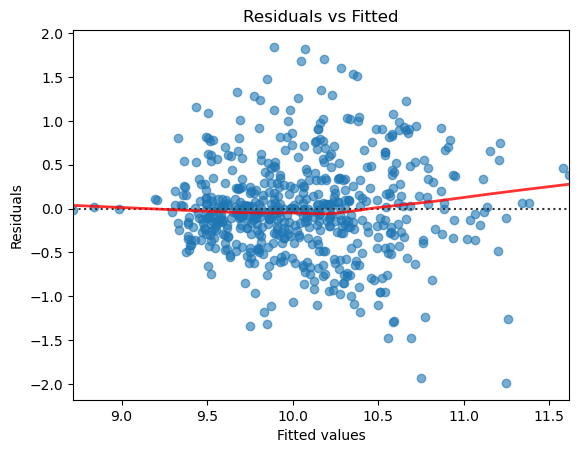

In [197]:
fig_1 = plt.figure(1)
fig_1.axes[0] = sns.residplot(data['hat_log_price'], data['log_price'],
                                  lowess=True,
                                  scatter_kws={'alpha': 0.6},
                                  line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8})
fig_1.axes[0].set_title('Residuals vs Fitted')
fig_1.axes[0].set_xlabel('Fitted values')
fig_1.axes[0].set_ylabel('Residuals')
plt.show()

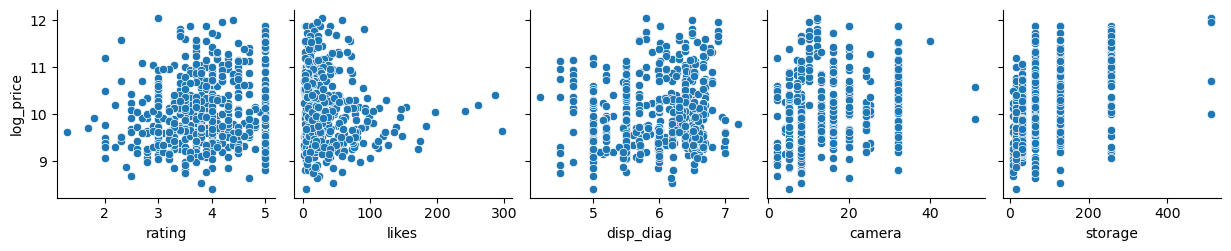

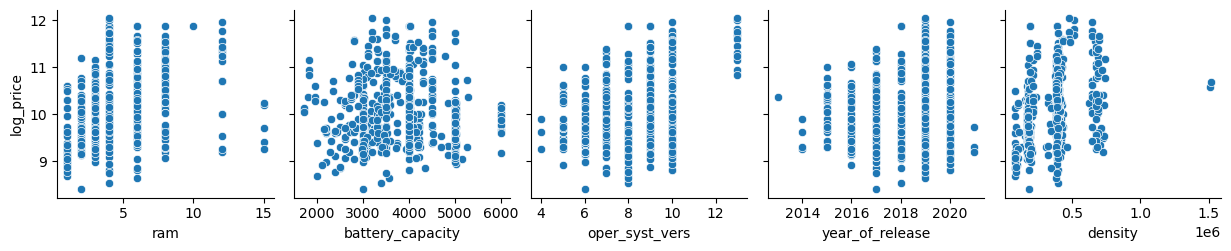

In [217]:
sns.pairplot(data, x_vars=X_columns[0:5], y_vars=["log_price"])
sns.pairplot(data, x_vars=X_columns[5:10], y_vars=["log_price"])
# sns.pairplot(data, x_vars=X_columns[10:15], y_vars=["log_price"]) # Неинтерпретируемые графики
# sns.pairplot(data, x_vars=X_columns[15:20], y_vars=["log_price"]) # Неинтерпретируемые графики
plt.show()

#### 3.1 Тест на проверку гетероскедостичности

$$\begin{align}
&H0: \sigma_{i}^2  = \sigma^2, \forall \ i \in \ \{0,1,2,3,4,5\} \ (гомоскедостичность) \\
&H1: \exists \ i, j : \sigma_{i}^2  \neq \sigma_{k}^2 \ (гетероскедостичность)
\end{align}$$

#### 3.1.1 Тест Уйата

In [232]:
X = data.drop(columns = ['log_price'])
y = data['log_price']
model = sm.OLS(y, X).fit()


In [233]:
white_test = het_white(model.resid,  model.model.exog)


In [257]:
labels = ['Chi^2 observed statistic', 'Chi^2 obserrved statistic p-value', 'F-Statistic', 'F-Test p-value']
res_white = dict(zip(labels, white_test))
print(f"Chi^2 observed statistic: {res_white['Chi^2 observed statistic']}")
# print(f"Chi^2 critical Statistics = {sp.stats.chi2.isf(1-0.1, np.shape(model.model.exog)[1] - 1, loc=0)}") Проверить док
print(f"P-value = {res_white['Chi^2 obserrved statistic p-value']}")

Chi^2 observed statistic: 384.8791901727373
P-value = 8.295505890844987e-09


Нулевая гипотеза о гомоскедостичности остатков отвергается на любом разумном уровне значимости

#### 3.1.2 Бройша-Пагана

In [256]:
bp_test = het_breuschpagan(model.resid,  model.model.exog)
labels = ['Chi^2 observed statistic', 'Chi^2 obserrved statistic p-value', 'F-Statistic', 'F-Test p-value']
res_bp = dict(zip(labels, bp_test))
print(f"Chi^2 observed statistic: {res_bp['Chi^2 observed statistic']}")
# print(f"Chi^2 critical Statistics = {sp.stats.chi2.isf(1-0.1, np.shape(model.model.exog)[1] - 1, loc=0)}")  Проверить док
print(f"P-value = {res_bp['Chi^2 obserrved statistic p-value']}")


Chi^2 observed statistic: 109.98689588875175
P-value = 6.110391331857e-10


#### 3.1.3 Тест Голдфелда — Куандта

In [260]:
# goldfeldquandt = het_goldfeldquandt(model.resid,  model.model.exog)
# labels = ['F-statistics observed', 'F-statistics p-value', 'ordering']
# res_goldfeldquandt = dict(zip(labels, goldfeldquandt))
# print(f"F observed statistic: {res_goldfeldquandt['F-statistics observed']}")
# print(f"P-value = {res_goldfeldquandt['F-statistics p-value']}")



F observed statistic: 0.5680841361615733
P-value = 0.9999980797899858


### 3.2 Решение проблемы гетероскедостичности

Для решение этой проблемы воспользуюсь робастными оценками в форме Уайта

##### 3.2.1 Общая информации модели до применение робастных оценок

In [262]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     11.54
Date:                Mon, 08 May 2023   Prob (F-statistic):           2.09e-45
Time:                        18:03:59   Log-Likelihood:                -478.45
No. Observations:                 597   AIC:                             1027.
Df Residuals:                     562   BIC:                             1181.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            71.0736    108.854      0.653      0.514    -142.736     284.884
rating                0.0603      0.035      1.720      0.086      -0.009       0.129
likes                -0.0004      0.001     -0.497      0.620      -0.002       0.001
disp_diag            -0.0712      0.089     -0.799      0.425      -0.246       0.104
camera                0.0099      0.003      2.847      0.005       0.003       0.017
storage               0.0015      0.000      3.376      0.001       0.001       0.002
ram                   0.0456      0.014      3.231      0.001       0.018       0.073
battery_capacity  -6.872e-06   4.91e-05     -0.140      0.889      -0.000    8.96e-05
oper_syst_vers        0.0630      0.058      1.078      0.281      -0.052       0.178
year_of_release      -0.0304      0.054     -0.560      0.576      -0.137       0.076
density            4.161e-07   1.82e-07      2.287      0.023    5.88e-08    7.73e-07
Other_oper_syst      -0.1113      0.565     -0.197      0.844      -1.221       0.998
battery_type_LiPo     0.0036      0.064      0.057      0.955      -0.121       0.129
brand_BlackBerry     -0.7527      0.308     -2.440      0.015      -1.358      -0.147
brand_Cubot          -0.5407      0.376     -1.439      0.151      -1.279       0.198
brand_Gionee         -0.8968      0.488     -1.838      0.067      -1.855       0.061
brand_Google         -0.2216      0.279     -0.795      0.427      -0.769       0.326
brand_HTC            -0.7395      0.283     -2.613      0.009      -1.295      -0.184
brand_Honor          -0.3553      0.354     -1.004      0.316      -1.050       0.340
brand_Hotwav         -1.3859      0.631     -2.195      0.029      -2.626      -0.146
brand_Huawei         -0.7471      0.269     -2.773      0.006      -1.276      -0.218
brand_Infinix        -0.9560      0.294     -3.247      0.001      -1.534      -0.378
brand_LG             -0.3028      0.317     -0.956      0.339      -0.925       0.319
brand_Lava           -1.4167      0.485     -2.919      0.004      -2.370      -0.463
brand_Lenovo         -0.7762      0.332     -2.340      0.020      -1.428      -0.125
brand_Motorola       -0.0224      0.336     -0.067      0.947      -0.682       0.637
brand_Nokia          -0.8253      0.286     -2.890      0.004      -1.386      -0.264
brand_OnePlus        -0.1640      0.301     -0.545      0.586      -0.755       0.427
brand_Oppo           -0.8008      0.291     -2.754      0.006      -1.372      -0.230
brand_Realme         -0.8194      0.307     -2.667      0.008      -1.423      -0.216
brand_Samsung        -0.5533      0.275     -2.009      0.045      -1.094      -0.012
brand_Sony           -0.4474      0.318     -1.408      0.160      -1.072       0.177
brand_Tecno          -0.7005      0.283     -2.471      0.014      -1.257

##### 3.2.2 Применение робастных оценок

In [263]:
ols_robust = ols.get_robustcov_results()
ols_robust.summary()

C:\Users\Alexandr\anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 34, but rank is 33
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     161.4
Date:                Mon, 08 May 2023   Prob (F-statistic):          1.28e-262
Time:                        18:04:39   Log-Likelihood:                -478.45
No. Observations:                 597   AIC:                             1027.
Df Residuals:                     562   BIC:                             1181.
Df Model:                          34                                         
Covariance Type:                  HC1                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            71.0736     80.222      0.886      0.376     -86.498     228.645
rating                0.0603      0.034      1.755      0.080      -0.007       0.128
likes                -0.0004      0.001     -0.747      0.455      -0.001       0.001
disp_diag            -0.0712      0.080     -0.893      0.372      -0.228       0.085
camera                0.0099      0.004      2.480      0.013       0.002       0.018
storage               0.0015      0.001      2.886      0.004       0.000       0.003
ram                   0.0456      0.015      3.083      0.002       0.017       0.075
battery_capacity  -6.872e-06   4.47e-05     -0.154      0.878   -9.46e-05    8.09e-05
oper_syst_vers        0.0630      0.045      1.402      0.162      -0.025       0.151
year_of_release      -0.0304      0.040     -0.760      0.448      -0.109       0.048
density            4.161e-07   1.73e-07      2.403      0.017     7.6e-08    7.56e-07
Other_oper_syst      -0.1113      0.528     -0.211      0.833      -1.148       0.926
battery_type_LiPo     0.0036      0.063      0.057      0.955      -0.121       0.128
brand_BlackBerry     -0.7527      0.303     -2.483      0.013      -1.348      -0.157
brand_Cubot          -0.5407      0.393     -1.376      0.169      -1.312       0.231
brand_Gionee         -0.8968      0.241     -3.724      0.000      -1.370      -0.424
brand_Google         -0.2216      0.308     -0.720      0.472      -0.826       0.383
brand_HTC            -0.7395      0.228     -3.247      0.001      -1.187      -0.292
brand_Honor          -0.3553      0.428     -0.830      0.407      -1.196       0.485
brand_Hotwav         -1.3859      0.233     -5.939      0.000      -1.844      -0.928
brand_Huawei         -0.7471      0.211     -3.537      0.000      -1.162      -0.332
brand_Infinix        -0.9560      0.213     -4.481      0.000      -1.375      -0.537
brand_LG             -0.3028      0.257     -1.178      0.239      -0.808       0.202
brand_Lava           -1.4167      0.215     -6.600      0.000      -1.838      -0.995
brand_Lenovo         -0.7762      0.230     -3.371      0.001      -1.228      -0.324
brand_Motorola       -0.0224      0.303     -0.074      0.941      -0.617       0.572
brand_Nokia          -0.8253      0.222     -3.720      0.000      -1.261      -0.390
brand_OnePlus        -0.1640      0.230     -0.712      0.477      -0.616       0.288
brand_Oppo           -0.8008      0.251     -3.189      0.002      -1.294      -0.308
brand_Realme         -0.8194      0.230     -3.568      0.000      -1.271      -0.368
brand_Samsung        -0.5533      0.211     -2.624      0.009      -0.967      -0.139
brand_Sony           -0.4474      0.262     -1.705      0.089      -0.963       0.068
brand_Tecno          -0.7005      0.221     -3.166      0.002      -1.135

### 4. Спецификация модели